## Linear Regression Neural Network Model Implementation Colorectal Adenocarcinoma

#### Initializing Libraries and Importing Packages

In [25]:
import pandas as pd
import numpy as py
import statistics as stat
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import optim
from tensorflow.keras.optimizers import Adam  # Import Adam optimizer
from torch import nn
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error # Performance metrics

#### Importing Colorectal Patient Dataset

In [26]:
# set our dataset equal to ds variable
ds = pd.read_csv('Colorectal Dataset Modified Garik Kazanjian.csv')

# view first 5 lines of dataset
ds.head()

,Patient ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Aneuploidy Score,Buffa Hypoxia Score,TCGA PanCanAtlas Cancer Type Acronym,Cancer Type Detailed,Last Communication Contact from Initial Pathologic Diagnosis Date,Birth from Initial Pathologic Diagnosis Date,...,Ragnum Hypoxia Score,Sex,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,Tissue Source Site Code,TMB (nonsynonymous),Tumor Disease Anatomic Site,Tumor Type,Patient Weight,Medicinal Treatment
0,TCGA-A6-2671,85,STAGE IV,6TH,25.0,NaN,COAD,Colon Adenocarcinoma,1126.0,-31329.0,...,NaN,Male,Yes,No,A6,4.066667,Colon,Colon Adenocarcinoma,67.2,Fluorouacil
1,TCGA-A6-2674,71,STAGE IV,6TH,24.0,NaN,COAD,Mucinous Adenocarcinoma of the Colon and Rectum,1331.0,-26292.0,...,NaN,Male,Yes,No,A6,7.666667,Colon,"Colon Adenocarcinoma, Mucinous Type",85.6,Fluorouacil
2,TCGA-A6-2676,75,STAGE IIB,6TH,1.0,NaN,COAD,Colon Adenocarcinoma,711.0,-27403.0,...,NaN,Female,Yes,No,A6,NaN,Colon,Colon Adenocarcinoma,45.9,Fluorouacil
3,TCGA-A6-2677,68,STAGE IIIC,6TH,8.0,NaN,COAD,Colon Adenocarcinoma,541.0,-25143.0,...,NaN,Female,Yes,No,A6,7.766667,Colon,Colon Adenocarcinoma,55.2,Fluorouacil
4,TCGA-A6-2678,43,STAGE IIIB,6TH,7.0,NaN,COAD,Colon Adenocarcinoma,1286.0,-16030.0,...,NaN,Female,Yes,No,A6,1.733333,Colon,Colon Adenocarcinoma,96.1,Fluorouacil


#### Dataset Cleaning

In [27]:
# dropping all columns which are not included in our feature set
columns_drop = ['Patient ID', 'Oncotree Code', 'Progression Free Status', 'Tumor Type', 'Sex', 'Informed consent verified', 'Primary Lymph Node Presentation Assessment', 'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Site Code', 'American Joint Committee on Cancer Publication Version Type', 'Cancer Type Detailed', 'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code']
ds = ds.drop(columns=columns_drop)

# assigning each 'Cancer Stage Code'; COAD (colon/colon and rectum) 0; READ (rectum) 1
stage_dict = {
    '0:DiseaseFree': '0',
    '1:Recurred/Progressed': '1'}

# map each respective treatment with its number
ds['Disease Free Status'] = ds['Disease Free Status'].map(stage_dict)

# assigning each 'Cancer Stage Code'; COAD (colon/colon and rectum) 0; READ (rectum) 1
survival_dict = {
    '1:DEAD WITH TUMOR': '1',
    '0:ALIVE OR DEAD TUMOR FREE': '0'}

# map each respective treatment with its number
ds['Disease-specific Survival status'] = ds['Disease-specific Survival status'].map(survival_dict)


# assigning each 'Cancer Stage Code'; COAD (colon/colon and rectum) 0; READ (rectum) 1
gen_dict = {
    'EUR': '1',
    'EUR_ADMIX': '2',
    'AFR': '3',
    'AFR_ADMIX': '4'}

# map each respective treatment with its number
ds['Genetic Ancestry Label'] = ds['Genetic Ancestry Label'].map(gen_dict)




# assigning each 'Cancer Stage Code'; COAD (colon/colon and rectum) 0; READ (rectum) 1
acronym_dict = {
    'COAD': '0',
    'READ': '1'}

# map each respective treatment with its number
ds['TCGA PanCanAtlas Cancer Type Acronym'] = ds['TCGA PanCanAtlas Cancer Type Acronym'].map(acronym_dict)

# assigning each 'Cancer Stage Code' with an appropriate number according to its stage
stage_dict = {
    'STAGE I': '1',
    'STAGE II': '2',
    'STAGE IIA': '2.25',
    'STAGE IIB': '2.50',
    'STAGE IIC': '2.75',
    'STAGE III': '3',
    'STAGE IIIA': '3.25',
    'STAGE IIIB': '3.50',
    'STAGE IIIC': '3.75',
    'STAGE IV': '4',
    'STAGE IVA': '4.25',
    'STAGE IVB': '4.75',
    'NA': '0'}

# map each respective treatment with its number
ds['Neoplasm Disease Stage American Joint Committee on Cancer Code'] = ds['Medicinal Treatment'].map(stage_dict)

# assigning each treatment with an appropriate number according to its position within the column
treatment_dict = {
    'Fluorouacil': '1',
    'Leucovorin': '2',
    'Oxaliplatin': '3',
    'Bevacizumab': '4',
    'Radiation 1': '5'}

# map each respective treatment with its number
ds['Medicinal Treatment'] = ds['Medicinal Treatment'].map(treatment_dict)



# assigning each treatment with an appropriate number according to its position within the column
icd_dict = {
    'C80.1': '80.1',
    'C49.4': '49.4',
    'C20': '20',
    'C19': '19',
    'C18.9': '18.9',
    'C18.7': '18.7',
    'C18.6': '18.6',
    'C18.5': '18.5',
    'C18.4': '18.4',
    'C18.3': '18.3',
    'C18.2': '18.2',
    'C18.0': '18.0'}

# map each respective treatment with its number
ds['ICD-10 Classification'] = ds['ICD-10 Classification'].map(icd_dict)


# International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code

# assigning each treatment with an appropriate number according to its position within the column
hist_dict = {
    'C80.1': '80.1',
    'C49.4': '49.4',
    'C20': '20',
    'C19': '19',
    'C18.9': '18.9',
    'C18.7': '18.7',
    'C18.6': '18.6',
    'C18.5': '18.5',
    'C18.4': '18.4',
    'C18.3': '18.3',
    'C18.2': '18.2',
    'C18.0': '18.0'}

# map each respective treatment with its number
ds['ICD-10 Classification'] = ds['ICD-10 Classification'].map(hist_dict)




# assigning each treatment with an appropriate number according to its position within the column
neo_dict = {
    'Yes': '1',
    'No': '0'}

# map each respective treatment with its number
ds['New Neoplasm Event Post Initial Therapy Indicator'] = ds['New Neoplasm Event Post Initial Therapy Indicator'].map(neo_dict)

#Tissue Prospective Collection Indicator
# assigning each treatment with an appropriate number according to its position within the column
tiss_dict = {
    'Yes': '1',
    'No': '0'}

# map each respective treatment with its number
ds['Tissue Prospective Collection Indicator'] = ds['Tissue Prospective Collection Indicator'].map(tiss_dict)

# assigning each treatment with an appropriate number according to its position within the column
retro_dict = {
    'Yes': '1',
    'No': '0'}

# map each respective treatment with its number
ds['Tissue Retrospective Collection Indicator'] = ds['Tissue Retrospective Collection Indicator'].map(retro_dict)

# assigning each treatment with an appropriate number according to its position within the column
live_dict = {
    '1:DECEASED': '1',
    '0:LIVING': '0'}

# map each respective treatment with its number
ds['Overall Survival Status'] = ds['Overall Survival Status'].map(live_dict)




# assigning each treatment with an appropriate number according to its position within the column
mest_dict = {
    'M0': '0',
    'M1': '1',
    'M1A': '1.25',
    'M1B': '1.75',
    'MX': '5'}

# map each respective treatment with its number
ds['American Joint Committee on Cancer Metastasis Stage Code'] = ds['American Joint Committee on Cancer Metastasis Stage Code'].map(mest_dict)


# Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code
# assigning each treatment with an appropriate number according to its position within the column
lymh_dict = {
    'NX': '8',
    'N2B': '7',
    'N2A': '6',
    'N2': '5',
    'N1C': '4',
    'N1B': '3',
    'N1A': '2',
    'N1': '1',}

# map each respective treatment with its number
ds['Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code'] = ds['Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code'].map(lymh_dict)

# assigning each treatment with an appropriate number according to its position within the column
tum_dict = {
    'With Tumor': '0',
    'Tumor Free': '1',
    'NA': '2'}

# map each respective treatment with its number
ds['Person Neoplasm Cancer Status'] = ds['Person Neoplasm Cancer Status'].map(tum_dict)


# Progression Free Status

# assigning each treatment with an appropriate number according to its position within the column
#prog_dict = {
 #   '1:PROGRESSION': '1',
  #  '0:CENSORED': '0'}

# map each respective treatment with its number
#ds['Progression Free Status'] = ds['Progression Free Status'].map(prog_dict)

 # assigning each treatment with an appropriate number according to its position within the column
#sex_dict = {
 #   'Male': '1',
  #  'Female': '0'}

# map each respective treatment with its number
#ds['Sex'] = ds['Sex'].map(sex_dict)

# assigning each treatment with an appropriate number according to its position within the column
code_dict = {
    'G5': '8',
    'F5': '7',
    'El': '6',
    'DY': '5',
    'DT': '4',
    'DC': '3',
    'D5': '2',
    'CM': '1',
    'CL': '7',
    'CA': '6',
    'AZ': '5',
    'AY': '4',
    'AU': '3',
    'AM': '2',
    'AH': '1',
    'AG': '7',
    'AF': '6',
    'AD': '5',
    'AA': '4',
    'A6': '3',
    '5M': '2',
    '4T': '6',
    '4N': '5',
    '3L': '4'}

# map each respective treatment with its number
ds['Tissue Source Site Code'] = ds['Tissue Source Site Code'].map(code_dict)



# Tumor Disease Anatomic Site
ana_dict = {
    'Colon': '1',
    'Rectum': '0'}

# map each respective treatment with its number
ds['Tumor Disease Anatomic Site'] = ds['Tumor Disease Anatomic Site'].map(ana_dict)


# this for loop will iterate throughout the columns, check for empty values, and replace then with a -1
for column in ds:
    ds[column] = ds[column].replace(py.NaN,1)
    
# Set display option to show all columns
#pd.set_option('display.max_columns', None)
#
# Display the DataFrame
#print(ds)
# Attempt to convert all columns to numeric, coercing errors
for col in ds.columns:
    ds[col] = pd.to_numeric(ds[col], errors='ignore')




ds = ds[:-175]
ds.head()


,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,Aneuploidy Score,Buffa Hypoxia Score,TCGA PanCanAtlas Cancer Type Acronym,Last Communication Contact from Initial Pathologic Diagnosis Date,Birth from Initial Pathologic Diagnosis Date,Disease Free (Months),Disease Free Status,Months of disease-specific survival,...,Person Neoplasm Cancer Status,Progress Free Survival (Months),Ragnum Hypoxia Score,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,Tissue Source Site Code,TMB (nonsynonymous),Tumor Disease Anatomic Site,Patient Weight,Medicinal Treatment
0,85,1,25.0,1.0,0,1126.0,-31329.0,1.000000,1,43.758425,...,0,17.588848,1.0,1,0,3,4.066667,1,67.2,1
1,71,1,24.0,1.0,0,1331.0,-26292.0,1.000000,1,43.758425,...,1,24.164119,1.0,1,0,3,7.666667,1,85.6,1
2,75,1,1.0,1.0,0,711.0,-27403.0,42.903639,0,42.903639,...,1,42.903639,1.0,1,0,3,1.000000,1,45.9,1
3,68,1,8.0,1.0,0,541.0,-25143.0,1.000000,1,24.328501,...,1,24.328501,1.0,1,0,3,7.766667,1,55.2,1
4,43,1,7.0,1.0,0,1286.0,-16030.0,42.278989,0,42.278989,...,1,42.278989,1.0,1,0,3,1.733333,1,96.1,1


#### Initializing Training and Testing Set

In [28]:
# setting x equal to all columns with the exception of hospital disposition
X = ds.drop(columns='Medicinal Treatment')
# setting y equal to what we want to preidct (mortality or alive in hospdisposition column
y = ds['Medicinal Treatment']
# Fit the scaler on the X data and transform it
#scaler = StandardScaler()

#X = scaler.fit_transform(X)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

# dividing up our dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Initializing Regression Model

In [29]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        
        # Use super __init__ to inherit from parent nn.Module class
        super(Model, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, hidden_features)
        self.fc4 = nn.Linear(hidden_features, out_features)
                
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x) # ReLU activation
        x = self.fc2(x)
        x = F.relu(x) # ReLU activation
        x = self.fc3(x)
        x = F.relu(x) # ReLU activation
        x = self.fc4(x)
        
        return x

In [30]:
# Initialize the model
in_features = 30  # number of features in X
hidden_features = 200  # number of hidden features
out_features = 1  # number of output features
model = Model(in_features, hidden_features, out_features)

#### Loss and Function Optimizer

In [31]:
# Use Mean Squared Error loss for regression
criterion = nn.MSELoss()

# Adam is a good general purpose optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

#### Training Model

tensor([[ -3.5495],
        [  1.3519],
        [ -5.4652],
        [ -6.6778],
        [  5.7586],
        [-11.5042],
        [ -5.4321],
        [  1.9838],
        [  0.0680],
        [ -1.4379],
        [ -3.8626],
        [ -0.6563],
        [ -7.3734],
        [  2.4349],
        [ -1.1144],
        [ -3.2450],
        [ -2.5824],
        [ -1.9968],
        [ -2.0646],
        [ -4.2374],
        [ -2.9796],
        [ -2.4506],
        [ -4.3498],
        [ -8.1886],
        [ -8.9582],
        [  6.8315],
        [ -7.3597],
        [ -9.4929],
        [  1.5771],
        [ -8.6898],
        [ -2.1830],
        [ -6.8826],
        [  4.2055],
        [ -6.1400],
        [-11.5242],
        [ -7.7105],
        [ -7.2533],
        [ -0.1905],
        [  2.4828],
        [ -9.5370],
        [-12.9464],
        [ -3.2157],
        [ -5.8302],
        [ -8.5696],
        [ -4.6712],
        [ -1.1960],
        [ -8.8245],
        [  1.5746],
        [ -3.6075],
        [-38.8062],


C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([434])) that is different to the input size (torch.Size([434, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([87])) that is different to the input size (torch.Size([87, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-pack

tensor([[-128.7097],
        [-109.1111],
        [-111.6260],
        [-102.3040],
        [ -67.4904],
        [-103.1070],
        [ -85.0828],
        [ -81.5925],
        [ -87.0121],
        [ -98.4016],
        [-109.8025],
        [ -69.7202],
        [-119.8671],
        [ -61.3800],
        [ -82.7529],
        [ -93.5661],
        [ -46.5174],
        [ -84.2619],
        [ -84.9069],
        [ -99.2065],
        [ -82.5073],
        [ -88.9624],
        [ -97.9631],
        [ -65.1067],
        [ -80.9046],
        [ -87.6451],
        [ -87.3953],
        [ -80.7853],
        [ -91.8122],
        [-102.6866],
        [-107.6670],
        [-107.3682],
        [ -92.6973],
        [ -87.9308],
        [ -98.9048],
        [ -68.6708],
        [-101.4858],
        [-100.1184],
        [ -78.5531],
        [-115.6516],
        [-112.4921],
        [-107.1407],
        [ -87.6031],
        [-103.5659],
        [-104.7257],
        [-100.5834],
        [-119.4152],
        [-100

C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([434])) that is different to the input size (torch.Size([434, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([87])) that is different to the input size (torch.Size([87, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-pack

Training MSE: 873.9378051757812, R^2 Score: -1148.4890094893972
Test MSE: 1541.3350830078125, R^2 Score: -1753.3407642653349
Average Mean Squared Error 1411737.25
tensor([[-52.6517],
        [-43.6708],
        [-46.2480],
        [-42.4448],
        [-26.0989],
        [-43.6145],
        [-35.2770],
        [-32.5057],
        [-34.9977],
        [-39.9623],
        [-45.0237],
        [-28.2244],
        [-49.6442],
        [-24.3054],
        [-33.5590],
        [-38.4471],
        [-19.2151],
        [-34.3529],
        [-34.6190],
        [-40.7549],
        [-33.8169],
        [-36.3453],
        [-40.2292],
        [-25.5814],
        [-34.1851],
        [-34.0733],
        [-36.5077],
        [-34.2741],
        [-36.7796],
        [-42.9904],
        [-43.9860],
        [-44.6277],
        [-36.6507],
        [-36.5960],
        [-41.9693],
        [-29.1654],
        [-41.5636],
        [-40.4878],
        [-31.1789],
        [-48.3274],
        [-47.8035],
        [-44.0112

C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([434])) that is different to the input size (torch.Size([434, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([87])) that is different to the input size (torch.Size([87, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-pack

tensor([[1.6074],
        [1.4441],
        [1.2870],
        [1.0714],
        [1.0379],
        [0.8066],
        [0.8949],
        [1.0543],
        [1.0620],
        [1.2017],
        [1.2809],
        [0.8400],
        [1.3274],
        [0.7933],
        [0.9769],
        [1.1026],
        [0.4228],
        [0.9745],
        [0.9729],
        [1.0836],
        [0.8994],
        [1.0011],
        [1.0333],
        [0.7156],
        [0.5338],
        [1.3641],
        [0.8486],
        [0.6453],
        [1.2705],
        [1.0743],
        [1.4068],
        [1.2204],
        [1.3513],
        [0.9354],
        [0.7625],
        [0.4891],
        [0.6157],
        [1.3203],
        [1.0881],
        [1.1779],
        [0.9095],
        [1.3688],
        [0.9300],
        [1.0428],
        [1.2328],
        [1.3196],
        [1.3102],
        [1.3955],
        [0.8669],
        [3.4485],
        [1.3829],
        [1.4209],
        [1.3255],
        [1.2204],
        [1.3929],
        [1

C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([434])) that is different to the input size (torch.Size([434, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([87])) that is different to the input size (torch.Size([87, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-pack

tensor([[-11.1463],
        [ -9.7876],
        [ -9.4761],
        [ -8.6047],
        [ -6.5678],
        [ -8.2806],
        [ -7.1800],
        [ -7.4263],
        [ -7.8066],
        [ -8.6971],
        [ -9.5113],
        [ -6.1970],
        [-10.0948],
        [ -5.6977],
        [ -7.3467],
        [ -8.1006],
        [ -4.0206],
        [ -7.3990],
        [ -7.4566],
        [ -8.5606],
        [ -7.1795],
        [ -7.7756],
        [ -8.4691],
        [ -6.3726],
        [ -6.5248],
        [ -8.4179],
        [ -7.2327],
        [ -6.4589],
        [ -8.2518],
        [ -8.4594],
        [ -9.3904],
        [ -9.0032],
        [ -8.5469],
        [ -7.3606],
        [ -7.8736],
        [ -5.5104],
        [ -8.6626],
        [ -8.8762],
        [ -7.1645],
        [ -9.5318],
        [ -8.9509],
        [ -9.2407],
        [ -7.3692],
        [ -8.5418],
        [ -8.9660],
        [ -8.8293],
        [ -9.8963],
        [ -9.0096],
        [ -6.3716],
        [ -8.5669],


C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([434])) that is different to the input size (torch.Size([434, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([87])) that is different to the input size (torch.Size([87, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-pack

tensor([[-3.0271],
        [-3.1401],
        [-2.2728],
        [-1.9670],
        [-2.6263],
        [-1.2659],
        [-1.6617],
        [-2.4985],
        [-2.4824],
        [-2.5759],
        [-2.5719],
        [-1.8763],
        [-2.3330],
        [-2.0454],
        [-2.2172],
        [-2.1608],
        [-1.0281],
        [-2.1244],
        [-2.1430],
        [-2.2625],
        [-1.9711],
        [-2.1795],
        [-2.2647],
        [-2.7793],
        [-1.0648],
        [-3.2844],
        [-1.4496],
        [-0.9436],
        [-2.6533],
        [-1.6595],
        [-2.6191],
        [-2.0166],
        [-3.0246],
        [-1.6270],
        [-1.1265],
        [-0.8357],
        [-2.3109],
        [-2.6876],
        [-2.4576],
        [-1.9109],
        [-1.2498],
        [-2.4400],
        [-1.6804],
        [-1.7071],
        [-2.2805],
        [-2.5408],
        [-2.0480],
        [-2.8704],
        [-1.5673],
        [-5.8769],
        [-2.5394],
        [-2.5209],
        [-3.

C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([434])) that is different to the input size (torch.Size([434, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([87])) that is different to the input size (torch.Size([87, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-pack

tensor([[-1.9161],
        [-2.2329],
        [-1.2921],
        [-1.0599],
        [-2.1060],
        [-0.2995],
        [-0.9068],
        [-1.8258],
        [-1.7565],
        [-1.7410],
        [-1.6249],
        [-1.2853],
        [-1.2724],
        [-1.5494],
        [-1.5176],
        [-1.3495],
        [-0.6180],
        [-1.4026],
        [-1.4161],
        [-1.4020],
        [-1.2593],
        [-1.4134],
        [-1.4176],
        [-2.2784],
        [-0.3147],
        [-2.6049],
        [-0.6561],
        [-0.1828],
        [-1.8923],
        [-0.7297],
        [-1.6964],
        [-1.0629],
        [-2.2764],
        [-0.8436],
        [-0.1895],
        [-0.1946],
        [-1.4545],
        [-1.8449],
        [-1.8178],
        [-0.8681],
        [-0.1908],
        [-1.5099],
        [-0.9041],
        [-0.7719],
        [-1.3695],
        [-1.6836],
        [-0.9747],
        [-2.0359],
        [-0.9127],
        [-5.2269],
        [-1.6051],
        [-1.5591],
        [-2.

C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([434])) that is different to the input size (torch.Size([434, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([87])) that is different to the input size (torch.Size([87, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-pack

Test Loss: 13.357549667358398
Training MSE: 3.2518374919891357, R^2 Score: -3.2771368147027253
Test MSE: 14.032160758972168, R^2 Score: -14.971342944521124
Average Mean Squared Error 406497.34375
tensor([[ 6.8567],
        [ 5.0214],
        [ 6.5021],
        [ 6.1755],
        [ 2.2735],
        [ 7.4224],
        [ 5.1049],
        [ 3.5744],
        [ 4.0383],
        [ 4.8791],
        [ 5.8741],
        [ 3.3940],
        [ 7.1841],
        [ 2.4831],
        [ 4.0367],
        [ 5.0677],
        [ 2.6384],
        [ 4.2895],
        [ 4.3179],
        [ 5.4189],
        [ 4.3749],
        [ 4.6381],
        [ 5.3030],
        [ 1.8934],
        [ 5.7045],
        [ 3.1037],
        [ 5.6747],
        [ 5.8863],
        [ 4.2162],
        [ 6.6957],
        [ 5.5906],
        [ 6.5350],
        [ 3.8165],
        [ 5.4074],
        [ 7.2380],
        [ 4.9449],
        [ 5.4828],
        [ 4.8644],
        [ 3.3622],
        [ 7.4735],
        [ 8.2744],
        [ 5.8348],
      

C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([87])) that is different to the input size (torch.Size([87, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([434])) that is different to the input size (torch.Size([434, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-pack

Test Loss: 6.330326080322266
Training MSE: 6.78538179397583, R^2 Score: -7.924802585804654
Test MSE: 6.860574722290039, R^2 Score: -6.808676834802506
Average Mean Squared Error 357718.4375
tensor([[ 5.2934],
        [ 3.7770],
        [ 5.0236],
        [ 4.7439],
        [ 1.5618],
        [ 5.6920],
        [ 3.9193],
        [ 2.6528],
        [ 3.0423],
        [ 3.7329],
        [ 4.5275],
        [ 2.5862],
        [ 5.5256],
        [ 1.7983],
        [ 3.0765],
        [ 3.9071],
        [ 2.0117],
        [ 3.2987],
        [ 3.3201],
        [ 4.1670],
        [ 3.3609],
        [ 3.5625],
        [ 4.0744],
        [ 1.3404],
        [ 4.3617],
        [ 2.1596],
        [ 4.3513],
        [ 4.5148],
        [ 3.1663],
        [ 5.1512],
        [ 4.3216],
        [ 5.0364],
        [ 2.7792],
        [ 4.1562],
        [ 5.5513],
        [ 3.7940],
        [ 4.1561],
        [ 3.7043],
        [ 2.4778],
        [ 5.7419],
        [ 6.3634],
        [ 4.5087],
        [ 4.0

C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([434])) that is different to the input size (torch.Size([434, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([87])) that is different to the input size (torch.Size([87, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-pack

tensor([[ 1.5176e+00],
        [ 6.7856e-01],
        [ 1.6813e+00],
        [ 1.6654e+00],
        [-2.5912e-01],
        [ 2.4580e+00],
        [ 1.3604e+00],
        [ 3.5515e-01],
        [ 5.6392e-01],
        [ 8.8480e-01],
        [ 1.3021e+00],
        [ 5.7633e-01],
        [ 1.9224e+00],
        [ 9.0787e-02],
        [ 6.8955e-01],
        [ 1.1467e+00],
        [ 6.2355e-01],
        [ 8.4572e-01],
        [ 8.4885e-01],
        [ 1.2413e+00],
        [ 9.4039e-01],
        [ 9.6213e-01],
        [ 1.1913e+00],
        [-2.2983e-01],
        [ 1.8420e+00],
        [-2.1971e-01],
        [ 1.6768e+00],
        [ 1.9733e+00],
        [ 5.5520e-01],
        [ 2.0060e+00],
        [ 1.1733e+00],
        [ 1.7961e+00],
        [ 1.9609e-01],
        [ 1.4976e+00],
        [ 2.4410e+00],
        [ 1.6390e+00],
        [ 1.2122e+00],
        [ 8.2270e-01],
        [ 2.7553e-01],
        [ 2.2116e+00],
        [ 2.8156e+00],
        [ 1.3473e+00],
        [ 1.4269e+00],
        [ 1

C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([434])) that is different to the input size (torch.Size([434, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([87])) that is different to the input size (torch.Size([87, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\armkz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-pack

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

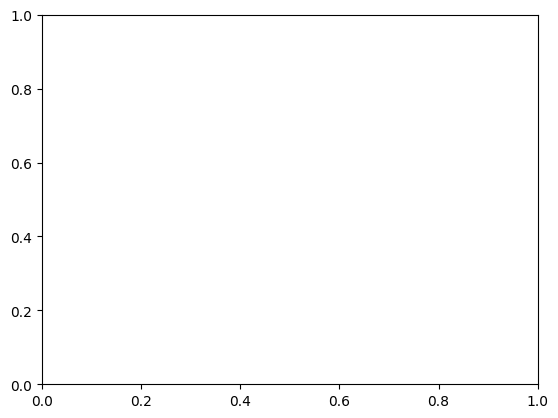

In [32]:
# Convert X and y to tensors
Xt = torch.Tensor(X.values)
yt = torch.Tensor(y.values)


# Define number of training epochs (passes over the training data)
epochs = 100

# Set up list to hold model loss with each epoch
losses = []
mse = []
# Loop through epochs
for i in range(epochs):
    i+=1
    # Reset model gradients
    optimizer.zero_grad()
    # Predict y (as a single batch)
    y_pred = model.forward(Xt)
    print(y_pred)
    # Calculate loss
    loss = criterion(y_pred, yt)
    # Backpropagate loss
    loss.backward()
    # Update network weights
    optimizer.step()
    # Record loss
    losses.append(loss)
    # Assuming Xt_test and yt_test are your test data
    Xt_test = torch.Tensor(X_test.values)
    yt_test = torch.Tensor(y_test.values)
    
    # Switch the model to evaluation mode
    model.eval()
    
    # Predict y for the test data
    y_pred_test = model(Xt_test)
    
    # Calculate the loss on the test data
    test_loss = criterion(y_pred_test, yt_test)
    
    print('Test Loss:', test_loss.item())

    from sklearn.metrics import mean_squared_error, r2_score
    
    # ... your existing code ...
    
    # Convert the tensor predictions to numpy arrays for sklearn metrics
    y_pred_np = y_pred.detach().numpy()
    y_pred_test_np = y_pred_test.detach().numpy()
    
    # Convert the tensor ground truth to numpy arrays for sklearn metrics
    yt_np = yt.numpy()
    yt_test_np = yt_test.numpy()
    
    # Calculate and print the training MSE and R^2 score
    mse_train = mean_squared_error(yt_np, y_pred_np)
    r2_train = r2_score(yt_np, y_pred_np)
    print(f'Training MSE: {mse_train}, R^2 Score: {r2_train}')
    
    # Calculate and print the test MSE and R^2 score
    mse_test = mean_squared_error(yt_test_np, y_pred_test_np)
    r2_test = r2_score(yt_test_np, y_pred_test_np)
    print(f'Test MSE: {mse_test}, R^2 Score: {r2_test}')

    mse.append(mse_test)
    print(f'Average Mean Squared Error {stat.mean(mse)}')
import matplotlib.pyplot as plt

plt.plot(range(epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()


#### Model Predictions

#### Model Evaluation

In [ ]:
# Recording Mean Squared Error
#print('Mean Squared Error: ',  mean_squared_error(y_test, predictions))

# Records R2-Squared Score of our model
#print("R2-Squared Score: ", r2_score(y_test, predictions))

# Records Median Absolute Error
#print("Median Absolute Error: ", median_absolute_error(y_test, predictions))

# Records Root Mean Squared Error
#print("Root Mean Squared Error (RMSE): ", py.sqrt(mean_squared_error(y_test, predictions)))